In [ ]:
figsize('inline_short')

from collections import OrderedDict
import json
from typing import List

from sp14.skm import SKM
from sp14.skm_util import *
from util import *

# SKM example

(2, 200)

(2, 200)

(2, 200)

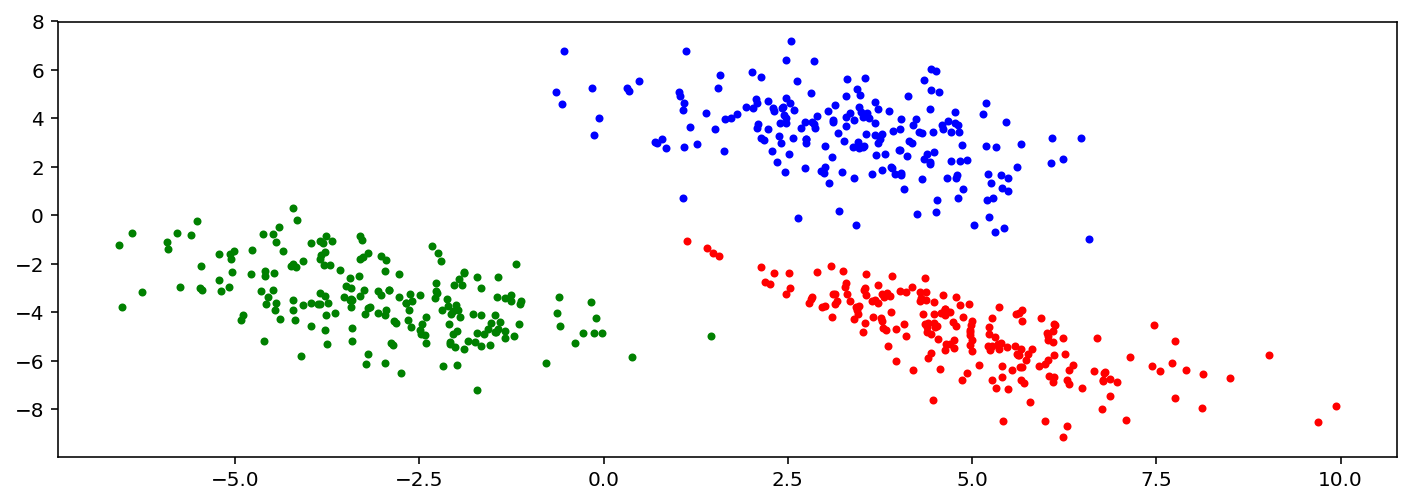

In [ ]:
# Generate training data
#   - skm expects data of the shape (freqs, patches)
npoints = 200
X_train = dict(
    a=np.array(polar_to_cart(
        r=5 + np.random.normal(size=npoints, scale=1),
        theta=np.pi/4.0 + np.random.normal(size=npoints, scale=np.pi/8.0),
    )),
    b=np.array(polar_to_cart(
        r=7 + np.random.normal(size=npoints, scale=2),
        theta=-np.pi/4.0 + np.random.normal(size=npoints, scale=np.pi/32.0),
    )),
    c=np.array(polar_to_cart(
        r=5 + np.random.normal(size=npoints, scale=1),
        theta=5/4.0  * np.pi + np.random.normal(size=npoints, scale=np.pi/8.0),
    )),
)
display(
    X_train['a'].shape,
    X_train['b'].shape,
    X_train['c'].shape,
)
plt.plot(X_train['a'][0], X_train['a'][1], 'b.')
plt.plot(X_train['b'][0], X_train['b'][1], 'r.')
plt.plot(X_train['c'][0], X_train['c'][1], 'g.')
plt.show()

(2, 600)

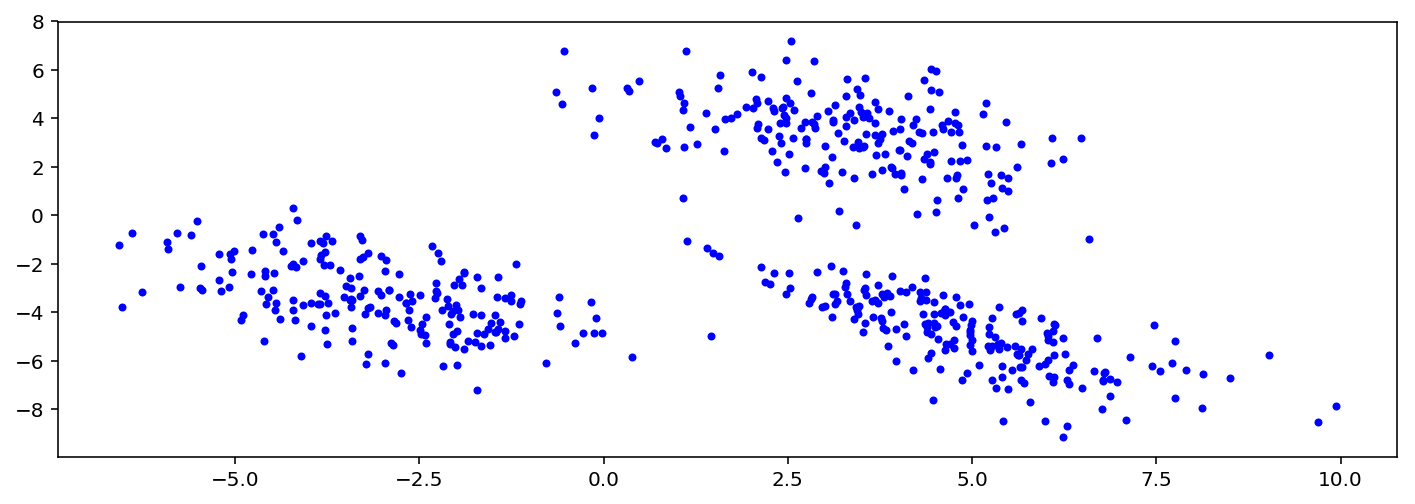

In [ ]:
# Combine into one unlabeled dataset and shuffle
X_train_nolab = np.concatenate((X_train['a'].T, X_train['b'].T, X_train['c'].T))
np.random.shuffle(X_train_nolab)
X_train_nolab = X_train_nolab.T
display(X_train_nolab.shape)
plt.plot(X_train_nolab[0,:], X_train_nolab[1,:], 'b.')
plt.show()

# Learn features
- Fit SKM centroids from the unlabeled version of the training data
- This produces an over-complete basis that we will use for the classification feature vectors

[22:56:46.341] [SKM] fit
[22:56:46.341] [SKM] _pca_fit_transform
[22:56:46.343] [SKM] fit: iterating...
[22:56:46.343] [SKM] epoch[1] assignment_change[1.0]
[22:56:46.344] [SKM] epoch[2] assignment_change[0.08166666666666667]
[22:56:46.344] [SKM] epoch[3] assignment_change[0.05]
[22:56:46.345] [SKM] epoch[4] assignment_change[0.03666666666666667]
[22:56:46.345] [SKM] epoch[5] assignment_change[0.023333333333333334]
[22:56:46.345] [SKM] epoch[6] assignment_change[0.025]
[22:56:46.346] [SKM] epoch[7] assignment_change[0.03166666666666667]
[22:56:46.346] [SKM] epoch[8] assignment_change[0.025]
[22:56:46.346] [SKM] epoch[9] assignment_change[0.03]
[22:56:46.347] [SKM] epoch[10] assignment_change[0.02]
[22:56:46.347] [SKM] epoch[11] assignment_change[0.015]
[22:56:46.347] [SKM] epoch[12] assignment_change[0.013333333333333334]
[22:56:46.348] [SKM] epoch[13] assignment_change[0.016666666666666666]
[22:56:46.348] [SKM] epoch[14] assignment_change[0.011666666666666667]
[22:56:46.348] [SKM] epo

'Fitted centroids:'

(2, 10)

array([[-0.844, -0.969, -0.956,  0.999,  0.819, -0.665, -0.306, -0.392,  0.965,  0.904],
       [-0.537,  0.249, -0.294,  0.033, -0.574, -0.747,  0.952, -0.92 , -0.263,  0.427]])

'Fitted whitening PCA:'

PCA(copy=False, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

array([[ 0.449,  0.894],
       [ 0.894, -0.449]])

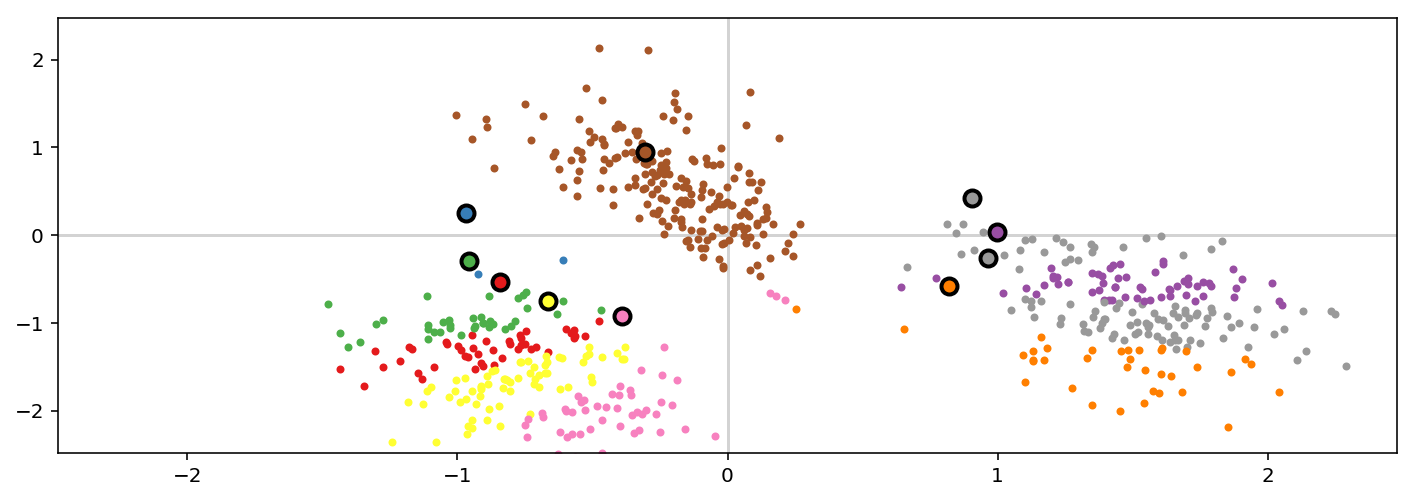

In [ ]:
skm = SKM(
    k=10,
    # variance_explained=0.99,
    # max_epocs=100,
    # assignment_change_eps=0.01,
    # standardize=False,
    # normalize=False,
    # do_pca=True,
    # pca_whiten=True,
    # visualize=False,
)

%time skm.fit(X_train_nolab)
display(
    'Fitted centroids:',
    skm.D.shape,
    skm.D,
    'Fitted whitening PCA:',
    skm.pca,
    skm.pca.components_,
)

skm_visualize_clusters(skm, X_train_nolab)
plt.show()


# Inspect the PCA whitening that SKM just did
- Whiten = decorrelate + standardize

In [ ]:
# Redo the whitening from skm.fit
X_train_nolab_white = skm.pca.transform(X_train_nolab.T).T

array([[14.059,  0.648],
       [ 0.648, 15.025]])

array([[1.000e+00, 5.931e-18],
       [5.931e-18, 1.000e+00]])

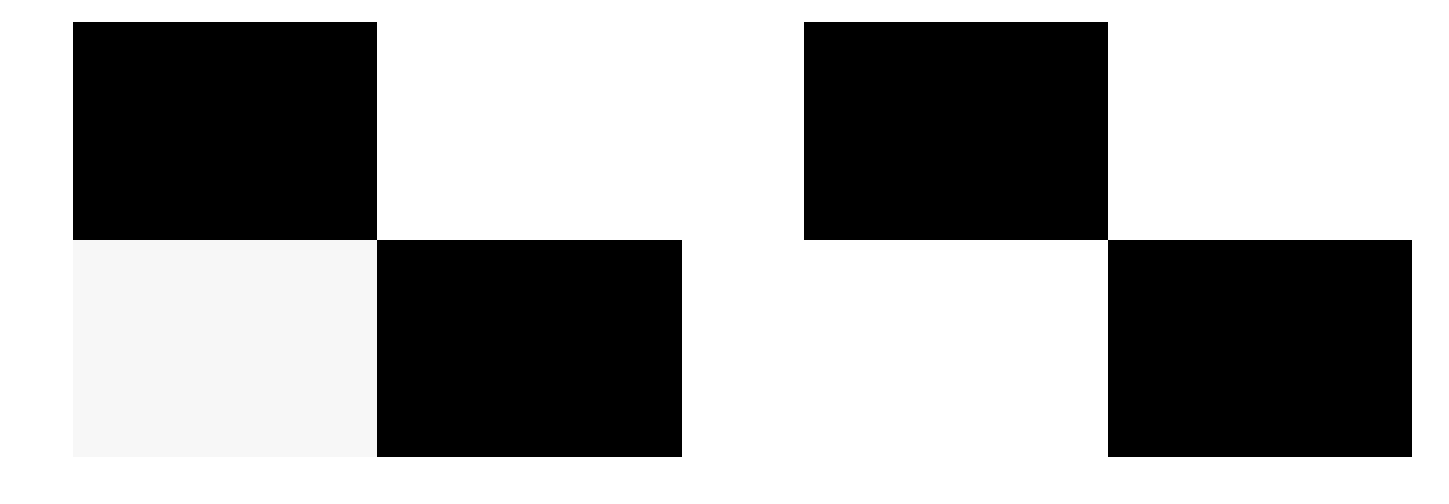

In [ ]:
# The whitened feature cov matrix should be ~I
for subplot, X in [
    (121, np.cov(X_train_nolab)),
    (122, np.cov(X_train_nolab_white)),
]:
    display(X)
    plt.subplot(subplot)
    plt.pcolormesh(X, cmap=mpl.cm.Greys_r)
    plt.axis('off')
plt.show()

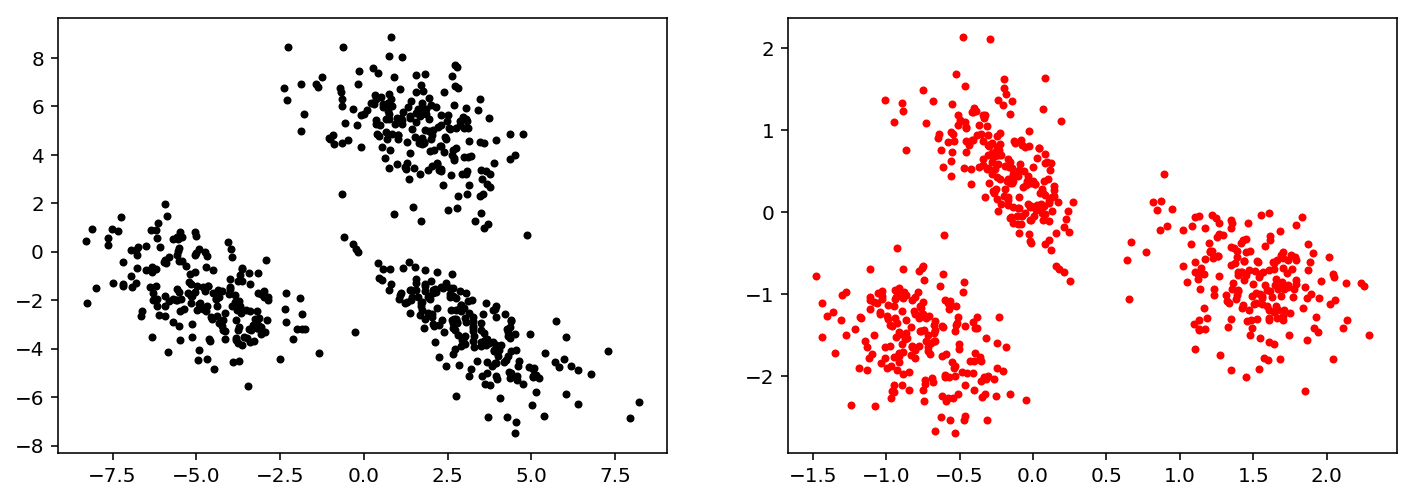

In [ ]:
# The whitened data should have "balanced" feature dimensions
plt.subplot(121); plt.plot(X_train_nolab[0,:], X_train_nolab[1,:], 'k.')
plt.subplot(122); plt.plot(X_train_nolab_white[0,:], X_train_nolab_white[1,:], 'r.')
plt.show()

# Project test data onto the fitted skm centroids

(2, 200)

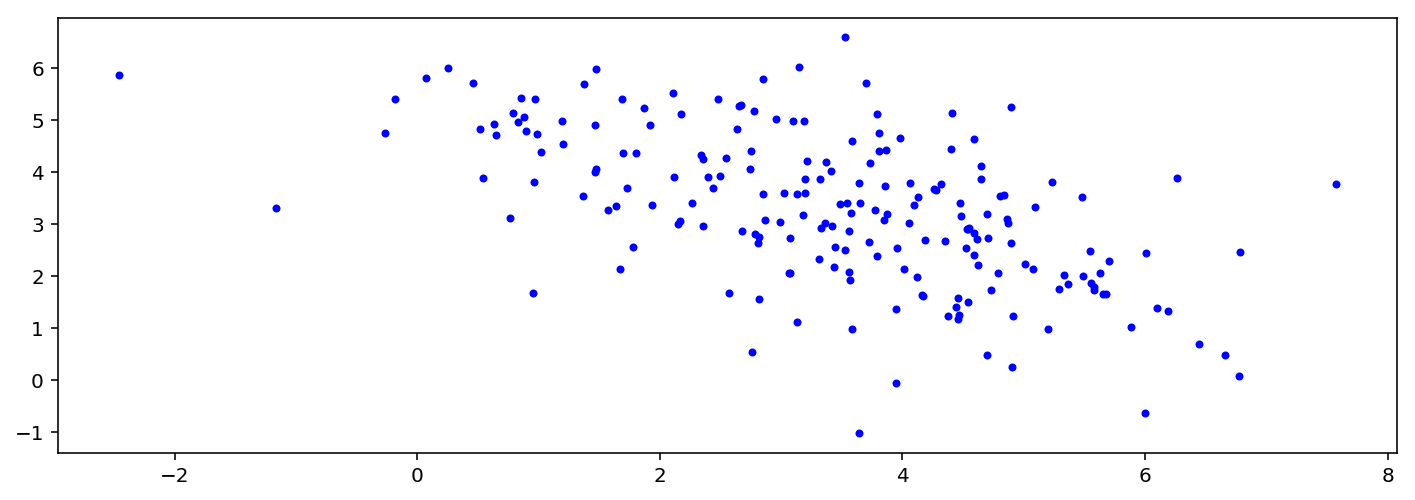

In [ ]:
# Generate some test data
X_test = np.array(polar_to_cart(
    r=5 + np.random.normal(size=200, scale=1),
    theta=np.pi/4.0 + np.random.normal(size=npoints, scale=np.pi/8.0),
))
display(X_test.shape)
plt.plot(X_test[0], X_test[1], 'b.')
plt.show()

[22:56:49.499] [SKM] transform
[22:56:49.499] [SKM] _pca_transform


(2, 200)

(10, 200)

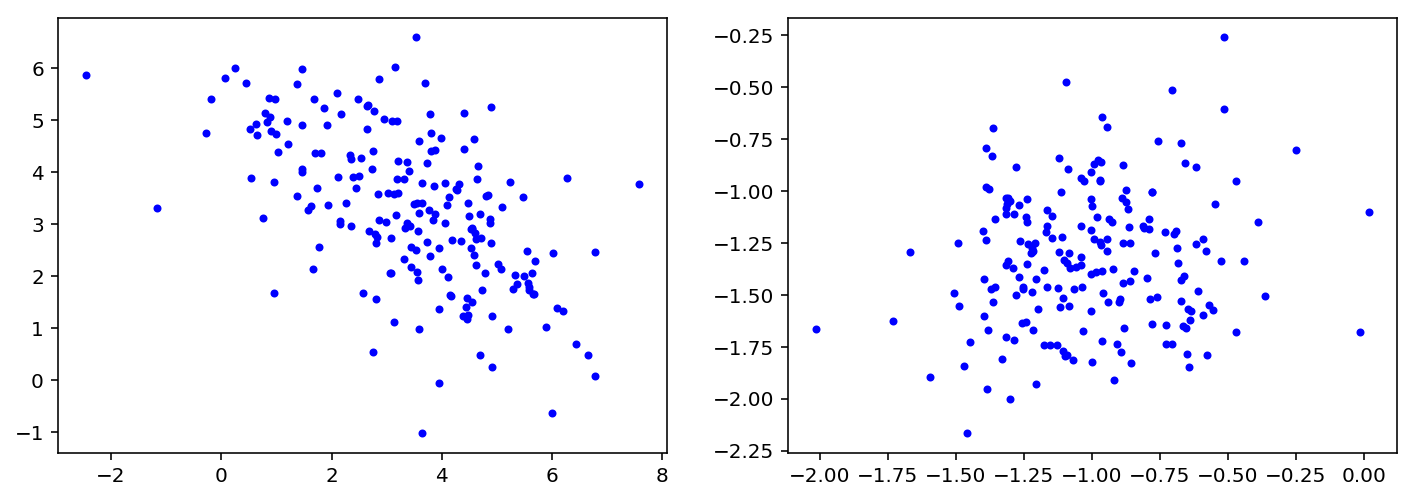

In [ ]:
# Project the test data using skm.transform, which:
#   - PCA whitens the test data, using the learned PCA from the (unlabeled) training data
#   - Projects the test data to the learned dictionary skm.D (i.e. the cluster centroids)
X_test_proj = skm.transform(X_test)
display(
    X_test.shape,  # n_freqs x n_patches
    X_test_proj.shape,  # n_centroids x n_patches
)
plt.subplot(121); plt.plot(X_test[0], X_test[1], 'b.')  # All 2 freq dims of the test data
plt.subplot(122); plt.plot(X_test_proj[0], X_test_proj[1], 'b.')  # Just the first two dims of X_test_proj (= first 2 PCs)
plt.show()

In [ ]:
# Aggregate the patches (= time = samples) dimension for each cluster centroid (= over-completion of freqs)
#   - Reduces dimensionality
#   - Forgets time structure (we don't need to mess with alignment -- but we do lose sequential structure of songs)

def agg_over_time(X: 'np.ndarray[n_centroids, n_patches]', aggs: List[str]) -> 'pd.DataFrame[n_centroids, n_aggs]':
    '''
    Aggregate each centroid row X[i,:] using each agg function ('mean', 'std', 'min', 'max', etc.)
    '''
    return pd.DataFrame(OrderedDict({
        agg: {
            'mean':     lambda X: np.mean(X, axis=1),
            'std':      lambda X: np.std(X, axis=1),
            'min':      lambda X: np.min(X, axis=1),
            'max':      lambda X: np.max(X, axis=1),
            'median':   lambda X: np.median(X, axis=1),
            'skewness': lambda X: scipy.stats.skew(X, axis=1),
            'kurtosis': lambda X: scipy.stats.kurtosis(X, axis=1),
            'dmean':    lambda X: np.mean(np.diff(X, axis=1), axis=1),
            'dstd':     lambda X: np.std(np.diff(X, axis=1), axis=1),
            'dmean2':   lambda X: np.mean(np.diff(np.diff(X, axis=1), axis=1), axis=1),
            'dstd2':    lambda X: np.std(np.diff(np.diff(X, axis=1), axis=1), axis=1),
        }[agg](X)
        for agg in aggs
    }))

# A friendly df of the aggregated centroid features [make tidy?]
#   - (n_centroids, n_patches) -> (n_centroids, n_aggs)
X_test_proj_agg_df = agg_over_time(X_test_proj, [
    'mean',
    'std',
    'max',
])

# The raw feature vector, which should finally be amenable to vanilla classification
#   - (n_centroids, n_patches) -> (n_centroids * n_aggs,)
X_test_proj_agg_flat = X_test_proj_agg_df.T.values.flatten()

display(
    X_test_proj.shape,
    X_test_proj_agg_df.shape,
    X_test_proj_agg_df,
    X_test_proj_agg_flat.shape,
    X_test_proj_agg_flat,
)

(10, 200)

(10, 3)

,mean,std,max
0,-1.010,0.306,0.020
1,-1.330,0.324,-0.260
2,-1.200,0.261,-0.385
3,1.310,0.267,2.070
4,1.190,0.419,2.120
5,-0.732,0.378,0.612
6,-0.591,0.522,0.657
7,-0.337,0.458,1.280
8,1.330,0.328,2.160
9,1.110,0.280,2.050


(30, )

array([-1.009, -1.328, -1.205,  1.314,  1.194, -0.732, -0.591, -0.337,  1.326,  1.11 ,  0.306,  0.324,  0.261,  0.267,
        0.419,  0.378,  0.522,  0.458,  0.328,  0.28 ,  0.02 , -0.26 , -0.385,  2.069,  2.12 ,  0.612,  0.657,  1.284,
        2.164,  2.047])